##DATA
###Census Business data:
download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/

and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)

$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

###NYC zip codes shape file is here
http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981
NOTES: to read in a zip file without unzipping it you can use the pandas and zipfile packages

import pandas as pd
import zipfiles #i am not giving it a name cause i intend to use it only once

zf = zipfile.ZipFile(fname)
df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix. Whitening your data in time series analysis is in most cases wrong: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). 

###Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. 

As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)
mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))
mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

##TASKS:
1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

In [1]:
from __future__ import print_function
__author__ = 'mo'
import pylab as pl
import numpy as np
%pylab inline

import pandas as pd
import geopandas as gp
import json

import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from scipy.cluster.vq import kmeans
import os
import zipfile

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

np.random.seed(123)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#making years dataframe 
years = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', 
         '04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
decades = arange(1994, 2014)

In [3]:
import zipfile

census_data = []
establishments = {}
counter = 0

#for loop to go into each file (with %) and replaceing each one with .txt
for i in years:
    filepath = 'zbp%stotals.zip' % i
    filezip = zipfile.ZipFile(filepath) 
    years = pd.read_csv(filezip.open(filepath.replace('.zip','.txt')))
#earlier data exploration showed files from years 1998-2002 headers change to caps, so we need to make them uniform
    years.columns = [x.upper() for x in years.columns]
    
    #extracting zip code and the number of establishments
    years = years[['ZIP', 'EST']]
    #rename the column with the year number
    years = years.rename(columns = {'EST': decades[counter]})
    census_data.append(years)
    counter +=1

establishments[0] = census_data[0]

for i in range(1,20):
#for each of the years, go into establishments and put them in ZIP rows
    establishments[i] = pd.merge(census_data[i], establishments[i-1], on=['ZIP']) 

census_df = establishments[19]

In [4]:
#sanity check
#census_df.head()
print(census_df.shape)
#gives us timestamps for all zips in USA

(35954, 21)


In [5]:
#reading in shapefile to get only NYC zips
shapeData = gp.read_file('nycpolygons.geojson')
shapeData['ZIP'] = shapeData.postalCode.astype(int)
#make an array of NYCzips as integers 
nyczips = shapeData.postalCode.astype(int)
#print(nyczips)

In [6]:
df = census_df.loc[census_df['ZIP'].isin(nyczips)]
df = df.reset_index(drop=True)

#print(df.shape)
#printing gives us 21 timestamps

#resetting the index to be the zipcode
df = df.set_index(['ZIP'])
df.shape
#df.head
#now we see 230 zips and 20 timestamps, all good!

(230, 20)

In [7]:
#save data as an array with .values, and put in order with fliplr
ordered_array = np.fliplr(df.values)
print(ordered_array)
print(ordered_array.shape)
#array looks NaN free!

[[6999 7088 7075 ..., 7227 7235 7273]
 [1784 1819 1919 ..., 2912 2954 2988]
 [3256 3377 3417 ..., 4159 4214 4277]
 ..., 
 [  95   90   88 ...,  131  129  127]
 [ 294  285  287 ...,  326  326  327]
 [  33   32   34 ...,   46   49   40]]
(230, 20)


In [8]:
#code for removing Nans

#badindex = []
#for i, est in enumerate(ordered_array):
#    if np.isnan(est).any():
#        badindex.append(i)  

#clean_est = np.delete(ordered_array, badindex, 0)

In [9]:
#creating shape for standardizing
d = ordered_array.shape

#making ordered_array into float variables
of_array = ordered_array.astype(float)

#standardize, with mean and std 
#FBB:I removed a for loop over the observations:
#rowmean is a float
#if you perform an algebraic operation on an array against a float 
#it will automatically get done over all elements of the array

for i in range(d[0]):
    rowmean = of_array[i].mean().astype(float)
    rowstd = of_array[i].std().astype(float)
    #standardize each row
    #for j in range(d[1]):
    of_array[i] = ((of_array[i] - rowmean)/rowstd)
print(of_array.shape)

(230, 20)


In [10]:
#the mean(1) and std(1) are operated on axis 1 (the observations)
#print(of_array.mean(1))
#print(of_array.std(1))
# gives array of 1, so we're good!
#we see standardization with means and stdvs

##Kmeans clustering

In [11]:
import scipy
import sklearn.cluster
#from sklearn import mixture
#from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2, vq


In [12]:
cluster2 = scipy.cluster.vq.kmeans(of_array, 2, iter=1)#, thresh=1e-05)
print("With 2 Clusters:") 
print(cluster2)
print("")

With 2 Clusters:
(array([[ 0.23989369,  0.43780639,  0.45158102,  0.49634962,  0.55239383,
         0.64832797,  0.73950977,  0.57887228, -0.02078724, -0.12273784,
         0.09403085, -0.03820737, -0.12928349, -0.2732822 , -0.43371813,
        -0.55005887, -0.66919119, -0.80415819, -0.6376703 , -0.5596706 ],
       [-1.40034889, -1.29929579, -1.16735749, -0.97071019, -0.85377202,
        -0.75234121, -0.63077269, -0.55982081, -0.17557255, -0.01060575,
         0.20365377,  0.33077561,  0.37520965,  0.53406493,  0.62572175,
         0.7290357 ,  0.95909309,  1.12857338,  1.33900685,  1.59546265]]), 2.1969867206425717)



In [13]:
#FBB this line of code retrieves the cluster labels:
#which zip belongs to which cluster

kmlabels2, kmdistances2 = vq(of_array, cluster2[0])
print ("2 clusters labels")
print (kmlabels2)
#print (kmdistances2)

2 clusters labels
[1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1]


In [14]:
cluster4 = scipy.cluster.vq.kmeans(of_array, 4, iter=20, thresh=1e-05)
kmlabels4, kmdistances4 = vq(of_array, cluster4[0])
cluster6 = scipy.cluster.vq.kmeans(of_array, 6, iter=20, thresh=1e-05)
kmlabels6, kmdistances6 = vq(of_array, cluster6[0])
cluster8 = scipy.cluster.vq.kmeans(of_array, 8, iter=20, thresh=1e-05)
kmlabels8, kmdistances8 = vq(of_array, cluster8[0])

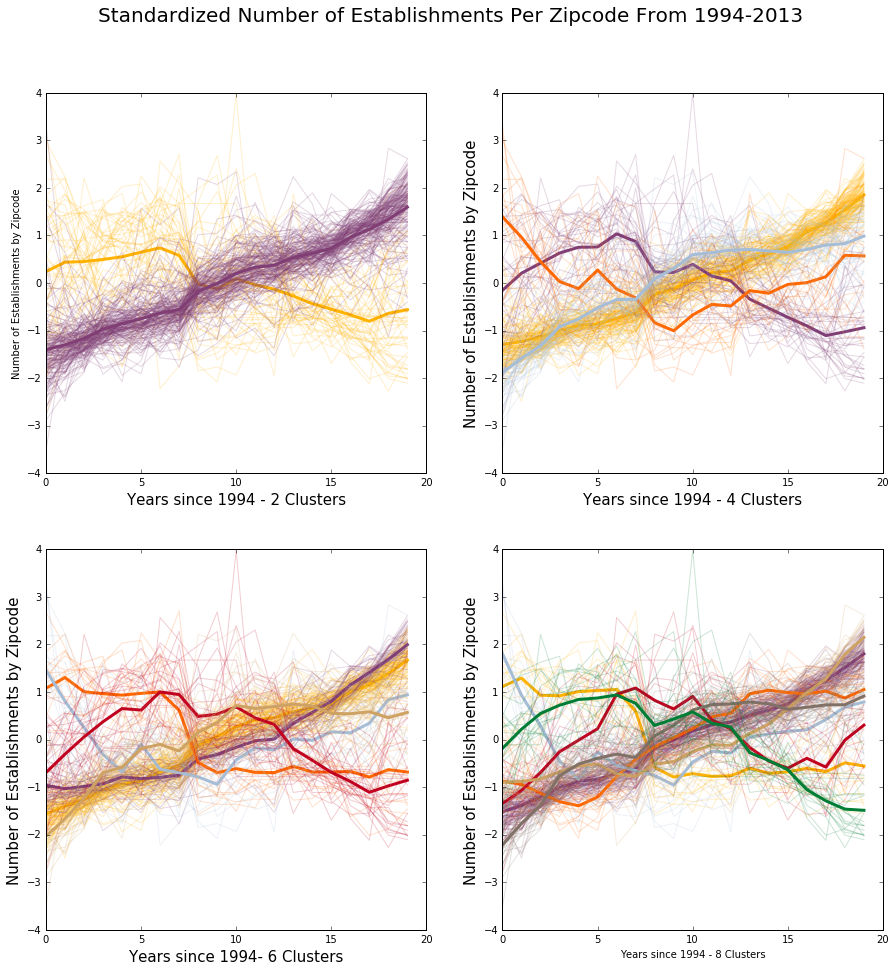

In [20]:
#plot all the clusters
#labels = decades
figsize(15,15)

#FBB now that i have the labels i can plot clusters in different colors

pl.subplot(2,2,1)
for l in range(2):
    pl.plot(of_array[kmlabels2 == l].T, 
            color = kelly_colors_hex[l], alpha = 0.2)
    pl.plot(cluster2[0][l].T, color = kelly_colors_hex[l], linewidth = 3) #, label = 'KMeans with 2 Clusters')
pl.xlabel('Years since 1994 - 2 Clusters', fontsize = 15)
pl.ylabel('Number of Establishments by Zipcode', fontsize = 10)
pl.suptitle('Standardized Number of establishments Per Zipcode From 1994-2013')
#pl.legend(loc = 0, fontsize = 6)

pl.subplot(2,2,2)
for l in range(4):
    pl.plot(of_array[kmlabels4 == l].T, 
            color = kelly_colors_hex[l], alpha = 0.2)
    pl.plot(cluster4[0][l].T, color = kelly_colors_hex[l], linewidth = 3) #, label = 'KMeans with 2 Clusters')
pl.xlabel('Years since 1994 - 4 Clusters', fontsize = 15)
pl.ylabel('Number of Establishments by Zipcode', fontsize = 15)
pl.suptitle('Standardized Number of Establishments Per Zipcode From 1994-2013')
#pl.legend(loc = 0, fontsize = 6)

pl.subplot(2,2,3)
for l in range(6):
    pl.plot(of_array[kmlabels6 == l].T, 
            color = kelly_colors_hex[l], alpha = 0.2)
    pl.plot(cluster6[0][l].T, color = kelly_colors_hex[l], linewidth = 3) #, label = 'KMeans with 2 Clusters')
pl.xlabel('Years since 1994- 6 Clusters', fontsize = 15)
pl.ylabel('Number of Establishments by Zipcode', fontsize = 15)
pl.suptitle('Standardized Number of Establishments Per Zipcode From 1994-2013')
#pl.legend(loc = 0, fontsize = 6)

pl.subplot(2,2,4)
for l in range(8):
    pl.plot(of_array[kmlabels8 == l].T, 
            color = kelly_colors_hex[l], alpha = 0.2)
    pl.plot(cluster8[0][l].T, color = kelly_colors_hex[l], linewidth = 3) #, label = 'KMeans with 2 Clusters')
pl.xlabel('Years since 1994 - 8 Clusters')
pl.ylabel('Number of Establishments by Zipcode', fontsize = 15)
pl.suptitle('Standardized Number of Establishments Per Zipcode From 1994-2013', fontsize = 20)
#pl.legend(loc = 0, fontsize = 6)

#Plotting on a NYC Map


In [21]:
df.head()

,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994
ZIP,,,,,,,,,,,,,,,,,,,,
10001,7273,7235,7227,7241,7305,7472,7549,7415,7312,7370,7084,7141,7188,7317,7233,7254,7154,7075,7088,6999
10002,2988,2954,2912,2872,2775,2691,2685,2686,2682,2551,2402,2269,2543,2277,2085,2003,2049,1919,1819,1784
10003,4277,4214,4159,4113,4099,4071,4049,3909,3867,3776,3704,3616,3602,3683,3659,3649,3535,3417,3377,3256
10004,1479,1442,1404,1398,1379,1376,1370,1311,1260,1283,1252,1253,1247,1294,1233,1176,1173,1133,1124,1115
10005,1296,1273,1301,1266,1274,1291,1273,1259,1214,1226,1200,1244,1249,1287,1242,1270,1227,1216,1109,1076


In [75]:
#shapeData.head()

In [22]:
#the problem with your call is that ZIP is not in the left DF:
#ZIP was the first row of your index. i reindex the dataframe, then i can merge
df.reset_index(inplace=True)
df.head()

,ZIP,2013,2012,2011,2010,2009,2008,2007,2006,2005,...,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994
0,10001,7273,7235,7227,7241,7305,7472,7549,7415,7312,...,7084,7141,7188,7317,7233,7254,7154,7075,7088,6999
1,10002,2988,2954,2912,2872,2775,2691,2685,2686,2682,...,2402,2269,2543,2277,2085,2003,2049,1919,1819,1784
2,10003,4277,4214,4159,4113,4099,4071,4049,3909,3867,...,3704,3616,3602,3683,3659,3649,3535,3417,3377,3256
3,10004,1479,1442,1404,1398,1379,1376,1370,1311,1260,...,1252,1253,1247,1294,1233,1176,1173,1133,1124,1115
4,10005,1296,1273,1301,1266,1274,1291,1273,1259,1214,...,1200,1244,1249,1287,1242,1270,1227,1216,1109,1076


In [23]:
mapmerge = pd.merge(df, shapeData, how = 'left', on = 'ZIP')
mapmerge.head()

/Users/mariaortiz/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)


,ZIP,2013,2012,2011,2010,2009,2008,2007,2006,2005,...,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,10001,7273,7235,7227,7241,7305,7472,7549,7415,7312,...,061,114,New York,NY,36,17794940.77290,19254.442129,Manhattan,POLYGON ((-74.00827017711134 40.75258714368449...,10001
1,10002,2988,2954,2912,2872,2775,2691,2685,2686,2682,...,061,124,New York,NY,36,26280128.59310,36484.417965,Manhattan,POLYGON ((-73.97441674489379 40.73642441865476...,10002
2,10003,4277,4214,4159,4113,4099,4071,4049,3909,3867,...,061,122,New York,NY,36,15538376.27380,17396.136890,Manhattan,POLYGON ((-73.97986374196766 40.73497446573838...,10003
3,10004,1479,1442,1404,1398,1379,1376,1370,1311,1260,...,061,139,New York,NY,36,4001782.18505,13769.878563,Manhattan,"POLYGON ((-74.00596661578348 40.7043243225291,...",10004
4,10004,1479,1442,1404,1398,1379,1376,1370,1311,1260,...,061,142,New York,NY,36,1202707.70742,6450.069454,Manhattan,POLYGON ((-74.04166368343016 40.69644987183209...,10004


##Plotting on Map

In [25]:

#FBB make it a GeoDataFrame instead of a regular df
#FBB you are not giving it the postal codes as an input: your geo dataframe 
#does not know anything about postal codes yet
cluster_columns = gp.GeoDataFrame(columns=('kmeans_2c', 
                                           'kmeans_4c', 
                                           'kmeans_6c', 
                                           'kmeans_8c'))
#print(cluster_columns)
cluster_columns['postalCode'] = df.index.astype(str)
#cluster_columns

In [26]:
#FBB aha! what you want here is not the clusters 
#to be in the cluster dataframe: cluster2 cluster3 etc 
#are the cluster centers
#what you want is the cluster assignments which i set to 
#kmlabels2 kmlabels4 etc...

cluster_columns['kmeans_2c'] = kmlabels2
cluster_columns['kmeans_4c'] = kmlabels4
cluster_columns['kmeans_6c'] = kmlabels6
cluster_columns['kmeans_8c'] = kmlabels8

In [27]:
mapmerge.head()
cluster_columns.head()

#FBB postal code in your columns DF is just an index, you did not save the actual pc in it
#hoefully it was indexed in the right order, 
#that is in the same order as mapmerge
#i aill go with that assumption though i did not check thorroughly (up to you)
#because they are indexed both on zip i can concatenate instead of merge
#shapeData = pd.merge(mapmerge, cluster_columns, on=['postalCode']) 
#shapeData.head()

shapeData2 = pd.concat([mapmerge, cluster_columns], axis=1)
shapeData2 = gp.GeoDataFrame(shapeData2)
shapeData2.head()


,ZIP,2013,2012,2011,2010,2009,2008,2007,2006,2005,...,Shape_Area,Shape_Leng,borough,geometry,postalCode,kmeans_2c,kmeans_4c,kmeans_6c,kmeans_8c,postalCode
0,10001,7273,7235,7227,7241,7305,7472,7549,7415,7312,...,17794940.77290,19254.442129,Manhattan,POLYGON ((-74.00827017711134 40.75258714368449...,10001,1,3,5,6,0
1,10002,2988,2954,2912,2872,2775,2691,2685,2686,2682,...,26280128.59310,36484.417965,Manhattan,POLYGON ((-73.97441674489379 40.73642441865476...,10002,1,0,0,1,1
2,10003,4277,4214,4159,4113,4099,4071,4049,3909,3867,...,15538376.27380,17396.136890,Manhattan,POLYGON ((-73.97986374196766 40.73497446573838...,10003,1,0,0,1,2
3,10004,1479,1442,1404,1398,1379,1376,1370,1311,1260,...,4001782.18505,13769.878563,Manhattan,"POLYGON ((-74.00596661578348 40.7043243225291,...",10004,1,0,0,1,3
4,10004,1479,1442,1404,1398,1379,1376,1370,1311,1260,...,1202707.70742,6450.069454,Manhattan,POLYGON ((-74.04166368343016 40.69644987183209...,10004,1,3,5,6,4


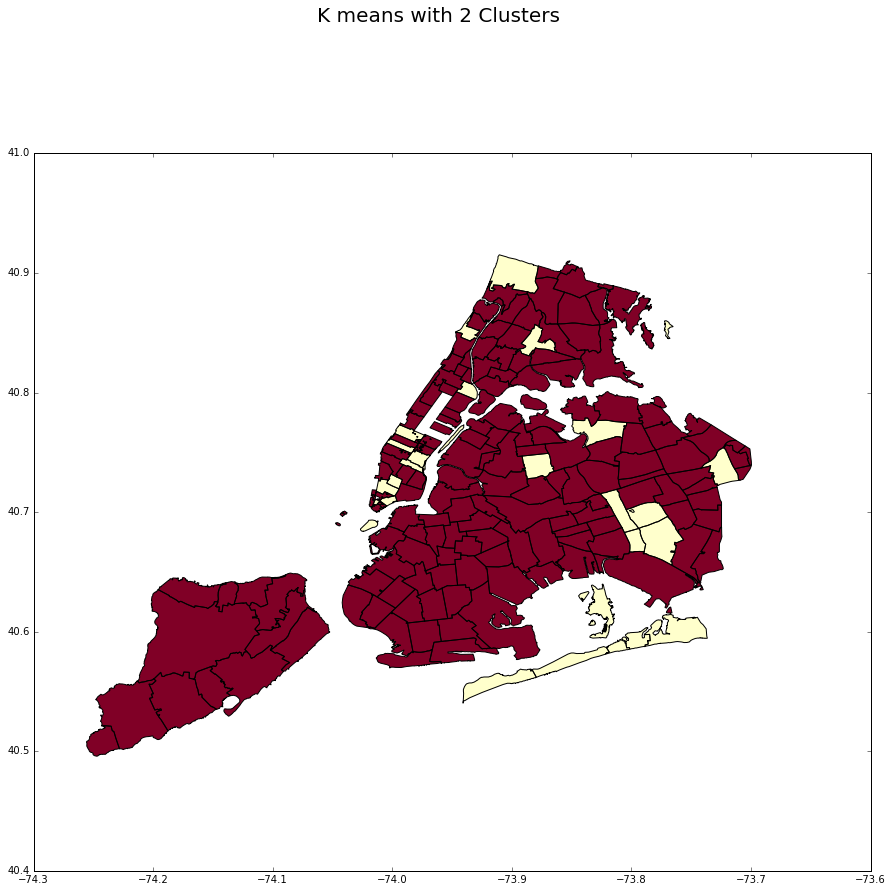

In [28]:
shapeData2.plot(column = 'kmeans_2c', alpha=1, colormap = 'YlOrRd')
pl.suptitle('K means with 2 Clusters', fontsize = 20)


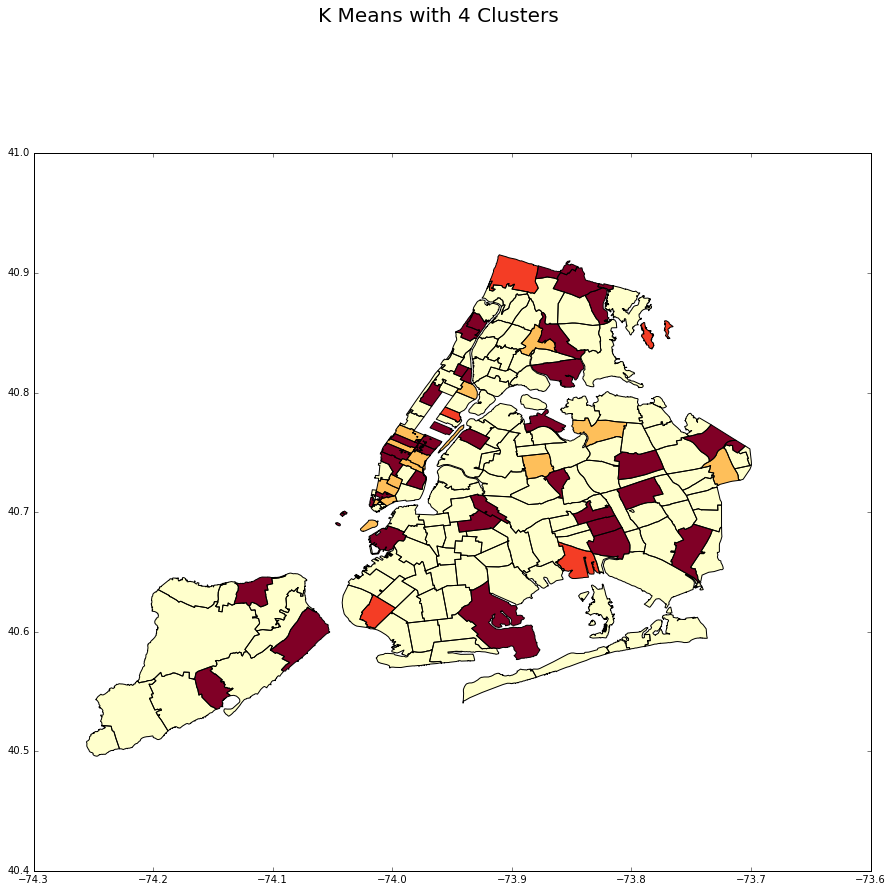

In [29]:
shapeData2.plot(column = 'kmeans_4c', alpha=1, colormap = 'YlOrRd')
pl.suptitle('K Means with 4 Clusters', fontsize = 20)


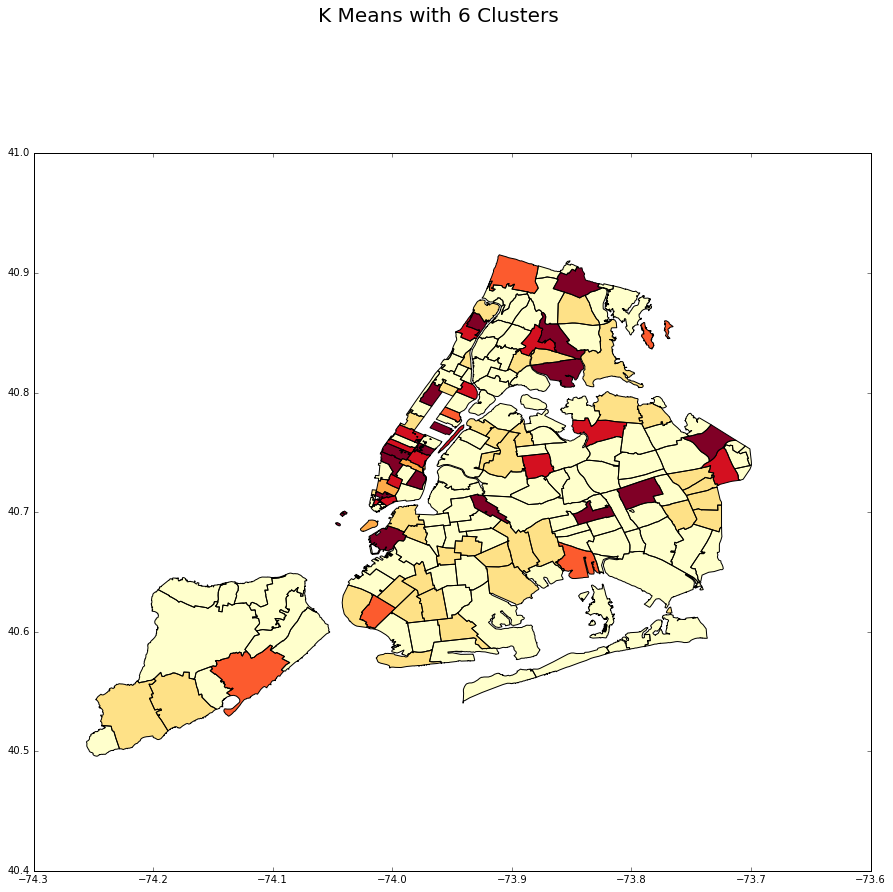

In [30]:
shapeData2.plot(column = 'kmeans_6c', alpha=1, colormap = 'YlOrRd')
pl.suptitle('K Means with 6 Clusters', fontsize = 20)

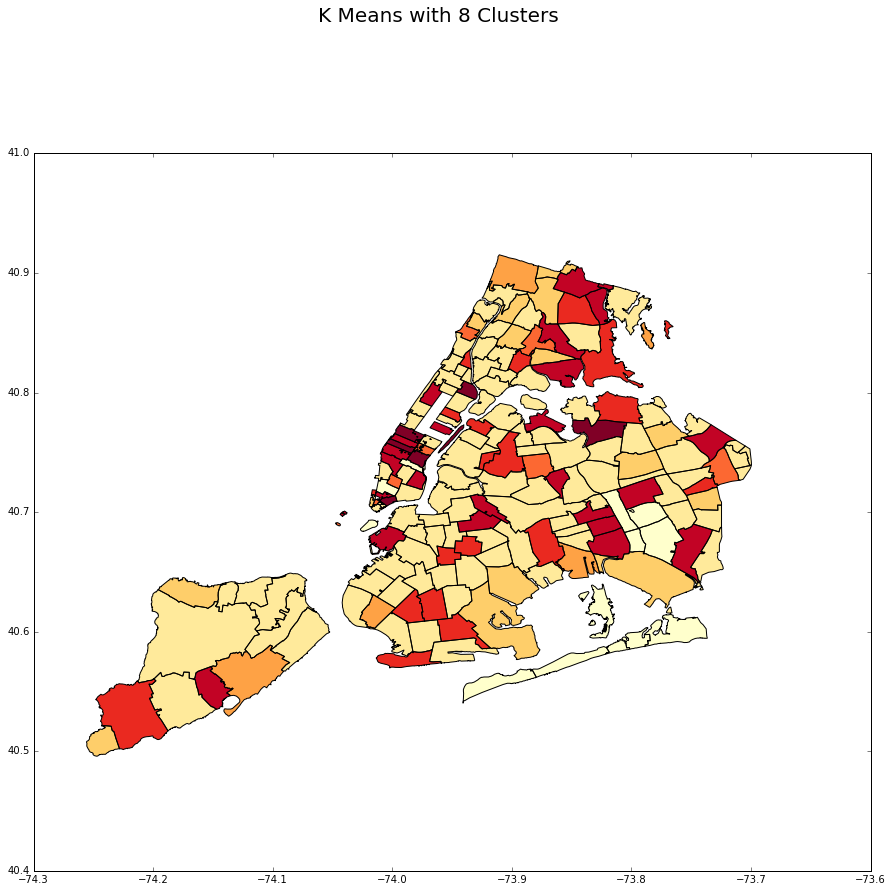

In [31]:
shapeData2.plot(column = 'kmeans_8c', alpha=1, colormap = 'YlOrRd')
pl.suptitle('K Means with 8 Clusters', fontsize = 20)

#DB SCAN

In [46]:
DBSCAN = sklearn.cluster.DBSCAN(eps=.55, min_samples=2, metric='euclidean',
                                    algorithm='auto').fit(of_array)
labels = (DBSCAN.labels_).astype(int)
print(labels)
num_clusters = len(set(labels))- (1 if -1 in labels else 0)

print("")
print('Number of Clusters: %d' %num_clusters)
len(labels)

[-1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
 -1 -1 -1  2 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  3 -1 -1  4  3 -1 -1 -1 -1 -1 -1 -1
  5  1 -1  1  1  0  1 -1 -1  0 -1  3 -1 -1  0 -1  1 -1  4 -1  0 -1 -1  4 -1
  1  2 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1
 -1 -1 -1 -1 -1]

Number of Clusters: 6


230

In [47]:
df['DBSCAN'] = labels

shapeData.shape

(262, 13)

In [ ]:
df.reset_index(inplace=True)
#df.head()

In [37]:
mapmerge2 = pd.merge(df, shapeData, how = 'left', on = 'ZIP')
mapmerge2.shape


(243, 36)

In [39]:
#mapmerge2.plot(column = i, alpha = .5, colormap = 'YlOrRd', figsize = (10, 10))
#pl.title('DBSCAN with %s Clusters' %num_clusters)
#this is not working! attempting something different...

In [66]:
plotDBSCAN = mapmerge2.join(pd.Series(labels, name = 'DBScan Cluster'))

In [67]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

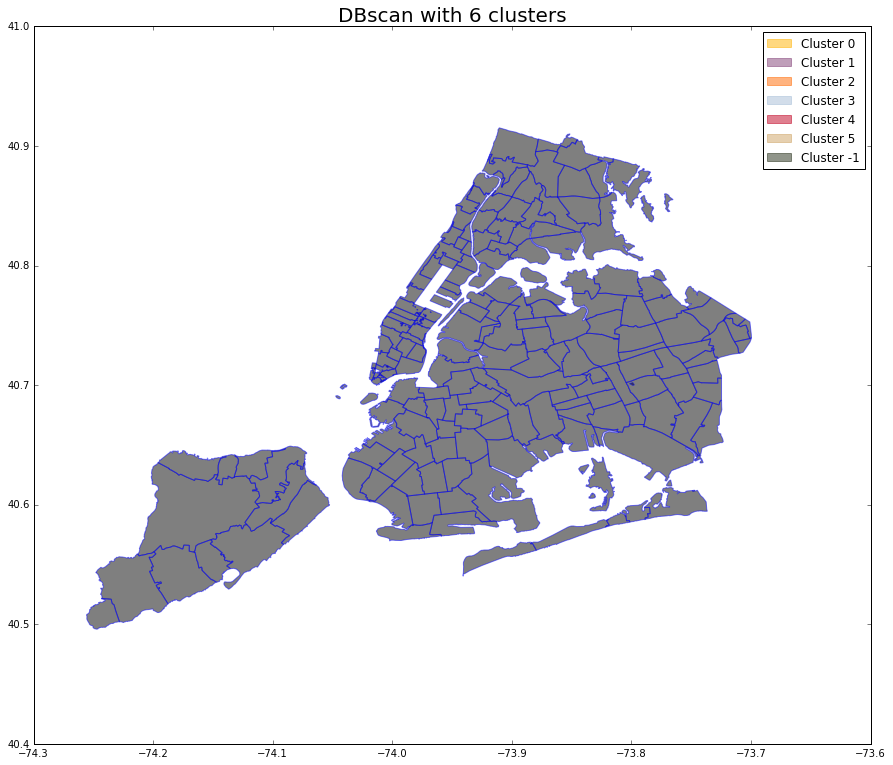

In [70]:
from descartes import PolygonPatch

fig = plt.figure(figsize=(15,15))

for i in range(len(plotDBSCAN)):
    poly = plotDBSCAN['geometry'][i]
    postcode = plotDBSCAN['ZIP'][i]
    cluster = plotDBSCAN['DBScan Cluster'][i]
    ax = fig.gca()
    #color = kelly_colors_hex[cluster]
    ax.add_patch(PolygonPatch(poly, fc='k', ec='b', alpha=0.5))
ax.axis('scaled')
ax.set_title('DBscan with 6 clusters', size=20)

import matplotlib.patches as mpatches

handles = []
for i in set(labels):
    patch = mpatches.Patch(color=kelly_colors_hex[i], alpha=0.5, label='Cluster {}'.format(i))
    handles.append(patch)
ax.legend(handles=handles,loc='best')

##Interpretation
I could not do the plot with the second algorithm, but what I can see from the first one, is that the data does have some stucture and the number of businesess appear to be have a general trend to increase.